In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision

from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [61]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [62]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Get MNIST

In [63]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


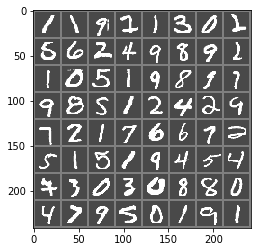

    1     1     9     7     1     3     0     2     5     6     2     4     9     8     9     2     1     0     5     1     9     8     9     7     9     8     5     1     2     4     2     9     7     2     1     7     6     6     7     2     5     1     5     1     9     4     5     4     7     3     0     3     0     8     8     0     4     7     9     5     0     1     9     1


In [64]:
# get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % int(labels[j]) for j in range(64)))

In [65]:
def kish_effs(weights):
    """Assume weights are just a list of numbers"""
    N = len(weights)
    weights = np.array(weights)
    sum_weights = np.sum(weights)
    return 1/float(N) *  sum_weights**2 / weights.dot(weights)

# Initialize nets and parameters

In [74]:
import torch.optim as optim

# Get n neural nets and init them
num_nets = 1
tau = 2500 # num batches before resampling
beta = -40

nets = [Net() for _ in range(num_nets)]

nets_weights = np.zeros(num_nets)

#  Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]

num_epochs = 5

effs_alpha = 0.4 # resample if kish less than this

dataloader = train_loader

## Try to do the example panos was talking about (x_i' - x_i)(x_j' - x_j) etc. 

# Training Loop 

In [167]:
# i would like to know the effective sampling time... 
# a problem here is in how we should measure the variance. we are only measuring a subset of the dataset at every step during an epch. 

# def train_input_reg(nets, dataloader, config):
    
epochs = num_epochs

running_losses = np.zeros(num_nets)

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.reshape(len(labels)).long()

        # cycle neural net
        curr_nn_idx = (i % len(nets))
        net = nets[curr_nn_idx]
        optimizer = optimizers[curr_nn_idx]

        # Compute gradients for input. 
        inputs.requires_grad = True

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        print(inputs.shape)
        loss = criterion(outputs.float(), labels)
        loss.backward(retain_graph=True)
        optimizer.step()


        # zero the parameter gradients + get input gradients
        optimizer.zero_grad()

        input_grads = []
        output_forb = torch.norm(outputs)
        output_forb.backward()
        input_grads = inputs.grad

        # update weights
        nets_weights[curr_nn_idx] = weight_function(input_grads, nets_weights[curr_nn_idx])

        # update statistics
        running_losses[curr_nn_idx] += loss.item()

        if i % (2000) == (1999):
            for n_i in range(num_nets):
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_losses[n_i]/float(2000)))
                running_losses[n_i] = 0.0
    
    print("help")


#     if kish_effs(weights) < effs_alpha:     
#         # resample particles
#         sampled_idx = sample_index_softmax(nets_weights, nets, beta=beta)
#         # init nets etc
#         nets = [copy.deepcopy(nets[i]) for i in sampled_idx]
#         optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]
#         nets_weights = np.zeros(num_nets)

#     return nets
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

KeyboardInterrupt: 

In [ ]:
def get_average_output(nets, inp):
    outs = [net(inp).detach().numpy() for net in nets]
    return np.mean(outs, axis=0)
    

In [76]:
# from: https://github.com/facebookresearch/jacobian_regularizer/blob/master/jacobian/jacobian.py
def _random_vector(C, B):
    '''
    creates a random vector of dimension C with a norm of C^(1/2)
    (as needed for the projection formula to work)
    '''
    if C == 1: 
        return torch.ones(B)
    v=torch.randn(B,C)
    arxilirary_zero=torch.zeros(B,C)
    vnorm=torch.norm(v, 2, 1,True)
    v=torch.addcdiv(arxilirary_zero, 1.0, v, vnorm)
    return v

In [86]:
images, labels = dataiter.next()

dim_x, dim_y = images[0].shape[1:]

In [95]:
rand_vecs = _random_vector(dim_x * dim_y, 2).reshape(2, dim_x, dim_y)

In [101]:
np.linalg.norm(images[0] - images[1])

29.709583

In [232]:
def classification_regions_2d(img_1, img_2, img_3, N, net):
    """img1 is center. img_2 is first orthogonal vector. use graham schmidt to get second vector from img_3. R
    Returns the alpha (X) and beta (Y) range used in the basis of v1 and v2. Use meshgrid(X, Y) to get the corresponding 
    coordinates for the result. """
    
    img1_to_img2 = img_2.reshape(np.product(img_1.shape[1:])) - img_1.reshape(np.product(img_1.shape[1:]))
    unit_img1_to_img2 = img1_to_img2 / np.linalg.norm(img1_to_img2)
    
    img1_to_img3 = img_3.reshape(np.product(img_1.shape[1:])) - img_1.reshape(np.product(img_1.shape[1:]))
    unit_img1_to_img3 = img1_to_img3 / np.linalg.norm(img1_to_img3)
    
    assert abs(unit_img1_to_img2.dot(unit_img1_to_img3)) != 1
    
    # get orthogonal vectors which span the above subspace. Use grahamschmidt
    v1 = unit_img1_to_img2
    v2 = unit_img1_to_img3 - v1.dot(unit_img1_to_img3) * v1
    v2 = v2 / np.linalg.norm(v2)
    
    
    v1_img = v1.reshape(img_1.shape[1:])
    v2_img = v2.reshape(img_2.shape[1:])
    
    # Get max/min alpha (v1) and beta (v2) 
    alpha_bound = 2*abs(v1.dot(img1_to_img2))
    beta_bound = 2*abs(v2.dot(img1_to_img3))
    
    alpha_range = np.linspace(-alpha_bound, alpha_bound, N)
    beta_range = np.linspace(-beta_bound, beta_bound, N)
    
    results = []
    
    mesh = np.array(np.meshgrid(alpha_range, beta_range))
    
    mesh_2d = mesh.reshape(2, N*N)
    
    for i in range(N*N):
        alpha, beta = mesh_2d[:, i]
        inp_img = img_1 + alpha*v1_img + beta*v2_img
        out = net(inp_img.reshape(1, inp_img.shape[0], inp_img.shape[1], inp_img.shape[2]))
        results.append(torch.argmax(out).detach().numpy())
            
    mesh = np.array(np.meshgrid(alpha_range, beta_range))
    return alpha_range, beta_range, np.array(results).reshape(mesh.shape[1:]), v1, v2

#             print("alpha {}".format(alpha))
#             print("beta {}".format(beta))
#             print(torch.argmax(out))

#     mesh = np.array(np.meshgrid(alpha_range, beta_range)).reshape(2, N*N)
    
#     alpha_vecs = [alpha * v1_img for alpha in alpha_range]
#     beta_vecs = [beta * v1_img for beta in beta_range]


In [ ]:
img1 = images[0]
img2 = images[1]
img3 = images[2]

label1 = float(labels[0].detach().numpy())
label2 = float(labels[1].detach().numpy())
label3 = float(labels[2].detach().numpy())


X, Y, results, v1, v2 = classification_regions_2d(img1, img2, img3, 5000, nets[0])

tensor(3.7719e-08)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
mesh.shape

In [ ]:
def get_vec(img):
    return img.reshape(np.product(img.shape[1:]))

img1_vec = get_vec(img1)
img2_vec = get_vec(img2)
img3_vec = get_vec(img3)

a1 = 0
b1 = 0

a2 = v1.dot(img2_vec - img1_vec)
b2 = v2.dot(img2_vec - img1_vec)

a3 = v1.dot(img3_vec - img1_vec)
b3 = v2.dot(img3_vec - img1_vec)



In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
            go.Heatmap(x = X, y=Y,
                    z=results,),

            go.Scatter(x=[a1], y=[b1], mode='markers', marker=dict(
                                                    color='LightSkyBlue',
                                                    size=20,
                                                    line=dict(
                                                        color='MediumPurple',
                                                        width=2
                                                    )
                                                )),
                        go.Scatter(x=[a2], y=[b2], mode='markers', marker=dict(
            color='LightSkyBlue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )),
                        go.Scatter(x=[a3], y=[b3], mode='markers', marker=dict(
            color='LightSkyBlue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ))

                     
                     ])


fig.show()

In [246]:
label3

array(2)